# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [30]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

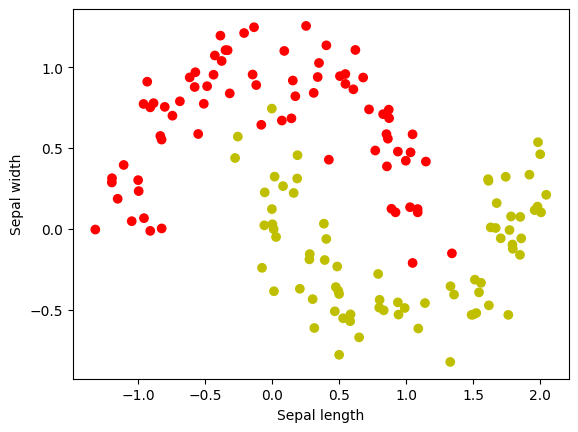

In [31]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [32]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [33]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [34]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [35]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [36]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0379)


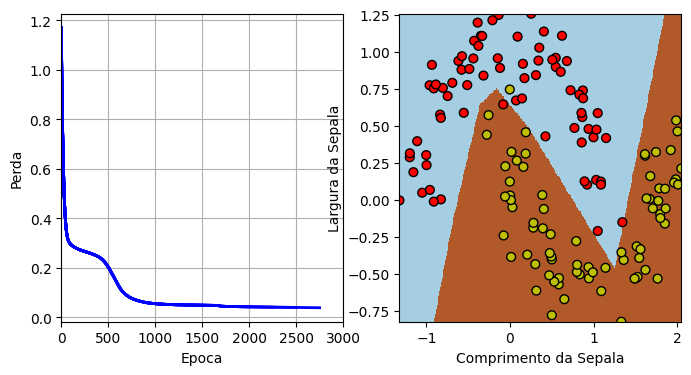

In [37]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [38]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 1.5064,  0.9905],
        [-0.7467,  0.9983],
        [ 0.2009, -0.8149],
        [ 2.1817,  0.2308],
        [-1.9236,  0.2692]])
dense.0.bias    torch.Size([5])
tensor([-0.1078, -0.3138,  0.8126, -2.6216, -0.5161])
dense.2.weight  torch.Size([5, 5])
tensor([[-1.0530e+00,  1.2982e-01,  1.0379e+00,  2.4741e+00, -1.4048e+00],
        [ 3.5530e-01,  6.2781e-01,  1.8452e-01, -1.1138e-02, -1.7535e-03],
        [ 5.9069e-02, -1.9149e-01,  2.7340e-01, -3.2755e-01,  2.4274e-01],
        [-1.2742e-01, -3.9559e-01, -2.6045e-01, -2.6818e-01,  2.1603e-02],
        [ 1.3667e+00,  7.3924e-01, -4.5053e-01, -2.3114e+00,  1.4941e+00]])
dense.2.bias    torch.Size([5])
tensor([ 1.1710,  1.0797, -0.4556, -0.0084,  0.3782])
dense.4.weight  torch.Size([3, 5])
tensor([[-1.7982,  0.6948, -0.1645,  0.1619,  2.5739],
        [ 2.8374,  0.6599, -0.4004,  0.0204, -1.9571],
        [-0.5260, -1.0230, -0.2029,  0.1153, -0.3211]])
dense.4.bias    torch.Size([3])
tensor([

### Avaliação do classificador

In [39]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.9866666666666667


### Matriz de confusão

In [40]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,74,1
1,1,74


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

Final loss: tensor(0.2937)


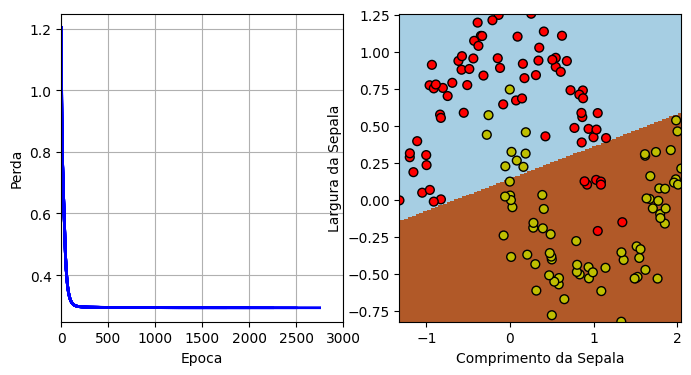

In [41]:
# QUESTÃO 1 - CENÁRIO 1

class Modelo2(nn.Module):
    def __init__(self):
        super().__init__()
        self.first = nn.Linear(2, 3)
        self.second = nn.Linear(3, 3)

    def forward(self, x):
        x = torch.relu(self.first(x))
        x = self.second(x)
        return x

model = Modelo2()
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

A perda percorre 3 fases: na primeira, há uma queda rápida no início das iterações; na segunda, há uma queda menos acentuada, que pode indicar a tentativa de melhoria do modelo; na terceira, uma estagnação, indicando que o modelo atingiu seu melhor desempenho possível dada sua capacidade e as features utilizadas.

Final loss: tensor(0.2509)


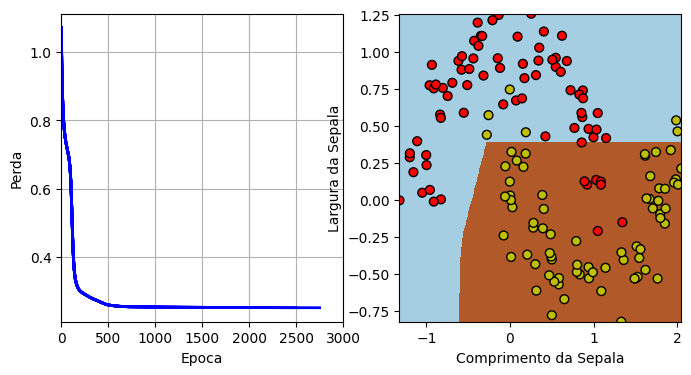

In [42]:
# QUESTÃO 1 - CENÁRIO 2

class Modelo3(nn.Module):
    def __init__(self):
        super().__init__()
        self.first = nn.Linear(2, 5)
        self.second = nn.Linear(5, 4)
        self.third = nn.Linear(4, 5)
        self.fourth = nn.Linear(5, 3)
    def forward(self, x):
        x = torch.relu(self.first(x))
        x = torch.relu(self.second(x))
        x = torch.relu(self.third(x))
        return self.fourth(x)

model = Modelo3()
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

Com o aumento do número de camadas (2 -> 4) e adição de mais neurônios, o modelo converge para a solução brevemente (próx. da época 1000).
A perda decai rapidamente nas primeiras iterações, apesar de um aumento significativo próx. a época 500, e estabiliza em um valor bem melhor que o modelo2.

Final loss: tensor(0.2971)


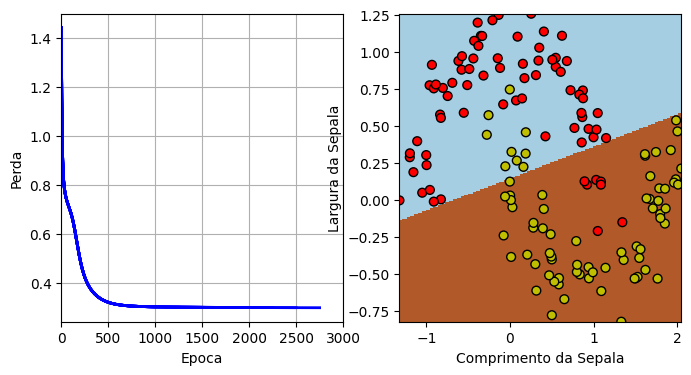

In [43]:
# QUESTÃO 2 - CENÁRIO 1

class Modelo2(nn.Module):
    def __init__(self):
        super().__init__()
        self.first = nn.Linear(2, 3)
        self.second = nn.Linear(3, 3)

    def forward(self, x):
        x = torch.sigmoid(self.first(x))
        x = self.second(x)
        return x

model = Modelo2()
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

Para o 1º cenário, a mudança da função para Sigmoid não foi suficiente para resolver o problema de classificação. Observa-se no gráfico à direita, que vários valores estão sendo classificados erroniamente.

Final loss: tensor(0.3009)


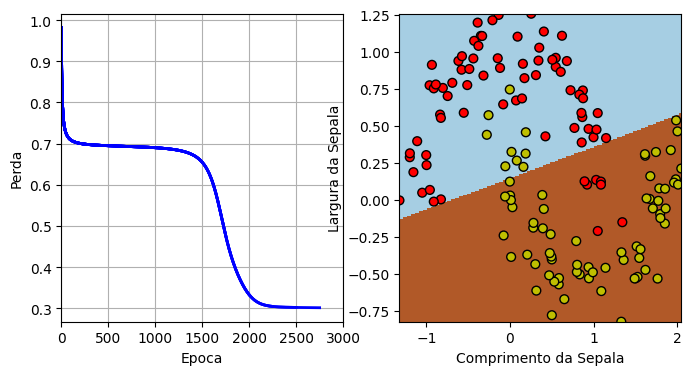

In [44]:
# QUESTÃO 2 - CENÁRIO 2

class Modelo3(nn.Module):
    def __init__(self):
        super().__init__()
        self.first = nn.Linear(2, 5)
        self.second = nn.Linear(5, 4)
        self.third = nn.Linear(4, 5)
        self.fourth = nn.Linear(5, 3)
    def forward(self, x):
        x = torch.sigmoid(self.first(x))
        x = torch.sigmoid(self.second(x))
        x = torch.sigmoid(self.third(x))
        return self.fourth(x)

model = Modelo3()
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

A troca da função de ativação ReLU para Sigmoid levou a um aprendizado lento e limitado. Como consequência, a fronteira de decisão tornou-se praticamente linear, incapaz de capturar a complexidade do problema. O modelo aprendeu pior, com perda mais alta e separação menos eficiente entre as classes, mesmo após a adição de mais camadas e neurônios.

Final loss: tensor(0.2937)


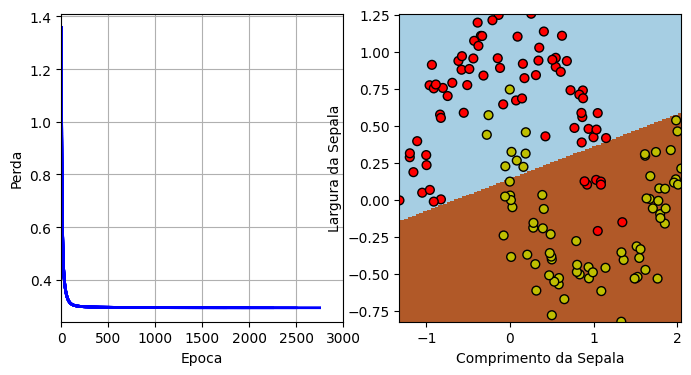

In [45]:
# QUESTÃO 3

class Modelo4(nn.Module):
    def __init__(self):
        super().__init__()
        self.first = nn.Linear(2, 5)
        self.second = nn.Linear(5, 3)

    def forward(self, x):
        # Sem ativação não-linear
        x = self.first(x)
        x = self.second(x)
        return x


model = Modelo4()
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

Sem ativação não linear entre camadas, a rede neural perde completamente sua capacidade de aprender padrões complexos e se reduz a uma transformação linear simples — equivalente a uma única camada. Ela não é capaz de resolver problemas não linearmente separáveis.